In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
from tqdm import tqdm
# import pickle

import sys
sys.path.append('../functions')
import hexbin_functions as hexfunc

/nethome/6525954/.conda/envs/nemo-ensemble/lib/python3.12/site-packages/h3/unstable/__init__.py:4: UserWarning: Modules under `h3.unstable` are experimental, and may change at any time.
  warnings.warn(


In [2]:
def entropy(Pdf):
    # Pdf = Pdf / np.nansum(Pdf)  # Normalize Pdf to sum to 1, ignoring NaNs
    # Replace zeros with a very small number to avoid log(0)
    Pdf_safe = np.where(Pdf > 0, Pdf, np.finfo(float).eps)
    return -np.nansum(Pdf_safe * np.log(Pdf_safe))

def information(Pdf):
    Pdf_safe = np.where(Pdf > 0, Pdf, np.finfo(float).eps)
    return - Pdf_safe * np.log2(Pdf_safe)

def Shannon_entropy(Pdf):
    # Pdf = Pdf / np.nansum(Pdf)  # Normalize Pdf to sum to 1, ignoring NaNs
    # Replace zeros with a very small number to avoid log(0)
    Pdf_safe = np.where(Pdf > 0, Pdf, np.finfo(float).eps)
    return -np.nansum(Pdf_safe * np.log2(Pdf_safe))

In [3]:
location = 'Cape_Hatteras'
delta_r = 0.1
subset = 1

file_path_AX = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_all/P_dr{delta_r*100:03.0f}_all_s{subset}.nc"
P_AX = xr.open_dataset(file_path_AX)

In [4]:
hex_grid = hexfunc.int_to_hex(P_AX.hexint.values)
hexbin_grid = hexfunc.hexGrid(hex_grid, h3_res=3)

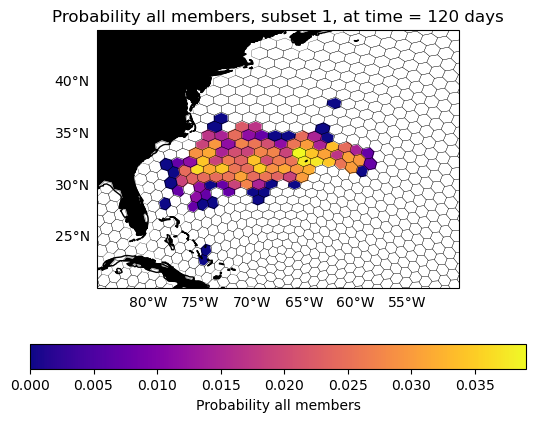

In [5]:

# Plot NA_domain on a map
depth = 0
fig = plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_extent([-85, -50, 20, 45], crs=cartopy.crs.PlateCarree())
ax.coastlines()

ax.add_feature(cartopy.feature.LAND, zorder=0, color='black')
gl = ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5, alpha=0.)
gl.top_labels = False
gl.right_labels = False


t = 120
t_gap = 0

im = hexbin_grid.pcolorhex(P_AX['probability'][:, t].values, ax=ax, cmap='plasma', draw_edges=True)
ax.set_title(f'Probability all members, subset {1}, at time = {t} days')


cbar = plt.colorbar(im, ax=ax, orientation='horizontal', label=f'Probability all members')


In [6]:
delta_r = 1.0

ncol = 3
nrow = 3
fig, axs = plt.subplots(ncols=ncol, nrows=nrow, figsize=(9, 6),
                       subplot_kw={'projection': cartopy.crs.PlateCarree()},
                       sharey=True, constrained_layout=True)

axs = axs.reshape(ncol*nrow)
t = 120

for i in range(0, 6):
    
    file_path_AX = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_all/P_dr{delta_r*100:03.0f}_all_s{i+1}.nc"
    P_AX = xr.open_dataset(file_path_AX)
    
    hex_grid = hexfunc.int_to_hex(P_AX.hexint.values)
    hexbin_grid = hexfunc.hexGrid(hex_grid, h3_res=3)
    
    axs[i].set_extent([-85, -50, 20, 45], crs=cartopy.crs.PlateCarree())
    axs[i].add_feature(cartopy.feature.LAND, zorder=0, color='black')
    
    axs[i].set_title(f'All Members Subset {i+1}')
    gl = axs[i].gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,
                         linewidth=0.5, color='gray', alpha=0.)

    im = hexbin_grid.pcolorhex(P_AX['probability'][:, t].values, ax=axs[i], cmap='plasma', draw_edges=True)

    if i in [1, 2, 4, 5]:
        gl.left_labels = False

    if i < 3:
        gl.bottom_labels = False

    gl.top_labels = False
    gl.right_labels = False

    if i in [2, 5]:
        gl.right_labels = True

for i in range(ncol*nrow - nrow, ncol*nrow):
    axs[i].axis('off')
    
bar_ax = fig.add_axes([0.1, 0.13, 0.8, 0.05])
cbar = fig.colorbar(im, cax=bar_ax, orientation='horizontal', label=f'Probability, at time = {t} days')

Text(0.5, 1.0, 'Shanon Entropy of the Subsets of All Members')

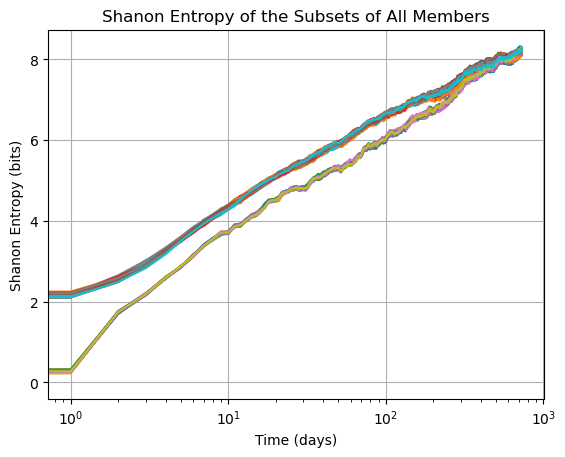

In [ ]:
for i in range(1, 51):
    delta_r = 0.1
    file_path_AX = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_all/P_dr{delta_r*100:03.0f}_all_s{i}.nc"
    P_AX = xr.open_dataset(file_path_AX)
    plt.semilogx(P_AX['entropy'][:])
    
    delta_r = 1
    file_path_AX = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_all/P_dr{delta_r*100:03.0f}_all_s{i}.nc"
    P_AX = xr.open_dataset(file_path_AX)
    plt.semilogx(P_AX['entropy'][:])

# plt.legend()
plt.ylabel('Shanon Entropy (bits)')
plt.xlabel('Time (days)')
plt.grid()
plt.title('Shanon Entropy of the Subsets of All Members')

In [ ]:
delta_r = 0.1

entropy_all = np.zeros((50, len(P_AX['entropy'].values)))
    
for i in range(1, 51):
    
    file_path_AX = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_all/P_dr{delta_r*100:03.0f}_all_s{i}.nc"
    P_AX = xr.open_dataset(file_path_AX)
    
    entropy_all[i-1, :] = P_AX['entropy'].values

mean_entropy_all_01 = np.mean(entropy_all, axis=0)
std_entropy_all_01 = np.std(entropy_all, axis=0)

In [ ]:
delta_r = 1

entropy_all = np.zeros((50, len(P_AX['entropy'].values)))
    
for i in range(1, 51):
    
    file_path_AX = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_all/P_dr{delta_r*100:03.0f}_all_s{i}.nc"
    P_AX = xr.open_dataset(file_path_AX)
    
    entropy_all[i-1, :] = P_AX['entropy'].values

mean_entropy_all_10 = np.mean(entropy_all, axis=0)
std_entropy_all_10 = np.std(entropy_all, axis=0)

Text(0.5, 1.0, 'Mean Shannon Entropy of the Subsets of All Members')

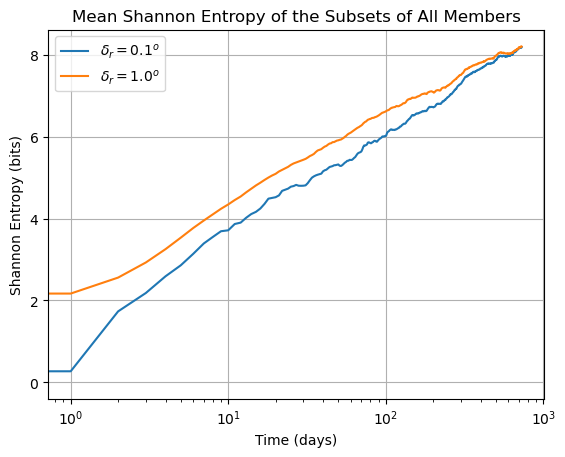

In [ ]:
plt.semilogx(mean_entropy_all_01, label=r'$\delta_r = 0.1^o$')
plt.semilogx(mean_entropy_all_10, label=r'$\delta_r = 1.0^o$')

plt.legend()
plt.ylabel('Shannon Entropy (bits)')
plt.xlabel('Time (days)')
plt.grid()
plt.title('Mean Shannon Entropy of the Subsets of All Members')


Text(0.5, 1.0, 'STD Shannon Entropy of the Subsets of All Members')

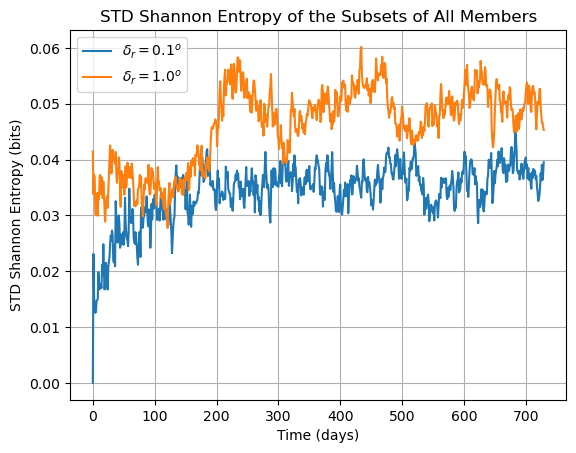

In [ ]:
plt.plot(std_entropy_all_01, label=r'$\delta_r = 0.1^o$')
plt.plot(std_entropy_all_10, label=r'$\delta_r = 1.0^o$')

plt.legend()
plt.ylabel('STD Shannon Entropy (bits)')
plt.xlabel('Time (days)')
plt.grid()
plt.title('STD Shannon Entropy of the Subsets of All Members')


# Temporal analysis

In [ ]:
location = 'Cape_Hatteras'
member = 42
week = 4

# file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_spatial/P_dr{delta_r*100:03.0f}_m{member:03d}.zarr"
file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_temporal/P_W{week:01d}_m{member:03d}.nc"

P_m = xr.open_dataset(file_path)
P_m = P_m.sortby('hexint')

In [ ]:
hex_grid = hexfunc.int_to_hex(P_m.hexint.values)
hexbin_grid = hexfunc.hexGrid(hex_grid, h3_res=3)

In [ ]:
# get dimensions
Members = np.arange(1, 51)
delta_r_ranges = np.linspace(1, 10, 10)/10
week_range = [4,8,12, 16]
time_array = P_m.time.values
bin_length = P_m.hexint.shape[0]

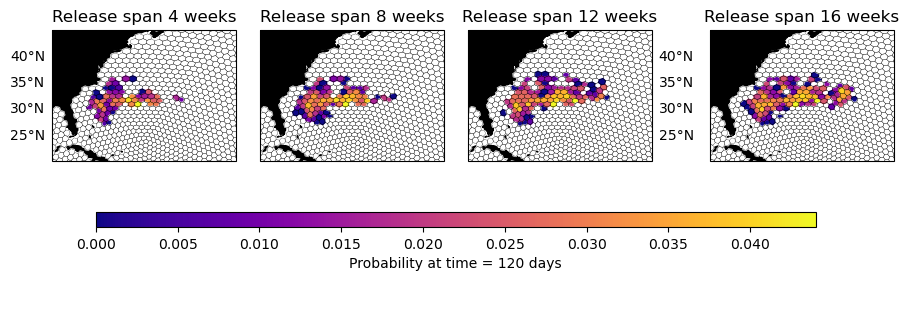

In [ ]:
member = 42

ncol = 4
nrow = 2
fig, axs = plt.subplots(ncols=ncol, nrows=nrow, figsize=(9, 3),
                       subplot_kw={'projection': cartopy.crs.PlateCarree()},
                       sharey=True, constrained_layout=True)

axs = axs.reshape(ncol*nrow)
t = 120

for i, week in enumerate(week_range):
    file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_temporal/P_W{week:01d}_m{member:03d}.nc"
    P_m = xr.open_dataset(file_path)
    P_m = P_m.sortby('hexint')
    
    axs[i].set_extent([-85, -50, 20, 45], crs=cartopy.crs.PlateCarree())
    axs[i].add_feature(cartopy.feature.LAND, zorder=0, color='black')
    
    axs[i].set_title(f'Release span {week} weeks')
    gl = axs[i].gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,
                         linewidth=0.5, color='gray', alpha=0.)

    im = hexbin_grid.pcolorhex(P_m['probability'][:, t].values, ax=axs[i], cmap='plasma', draw_edges=True)

    if i in [1, 2, 3, 4, 5]:
        gl.left_labels = False

    if i < 4:
        gl.bottom_labels = False

    gl.top_labels = False
    gl.right_labels = False

    if i in [2, 5]:
        gl.right_labels = True

for i in range(4, ncol*nrow):
    axs[i].axis('off')
    
bar_ax = fig.add_axes([0.1, 0.26, 0.8, 0.05])
cbar = fig.colorbar(im, cax=bar_ax, orientation='horizontal', label=f'Probability at time = {t} days')

(0.0, 10.0)

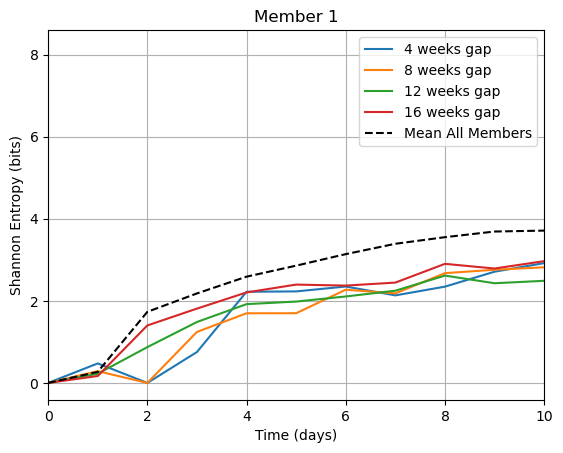

In [ ]:
member = 1

for i, week in enumerate(week_range):
    file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_temporal/P_W{week:01d}_m{member:03d}.nc"
    P_m = xr.open_dataset(file_path)
    P_m = P_m.sortby('hexint')
    plt.plot(P_m['entropy'][:], label=f'{week} weeks gap')
    
plt.plot(mean_entropy_all_01, ls='--', color='black', label='Mean All Members')

plt.legend()
plt.ylabel('Shannon Entropy (bits)')
plt.xlabel('Time (days)')
plt.title(f'Member {member}')
plt.grid()
plt.xlim(0, 10)

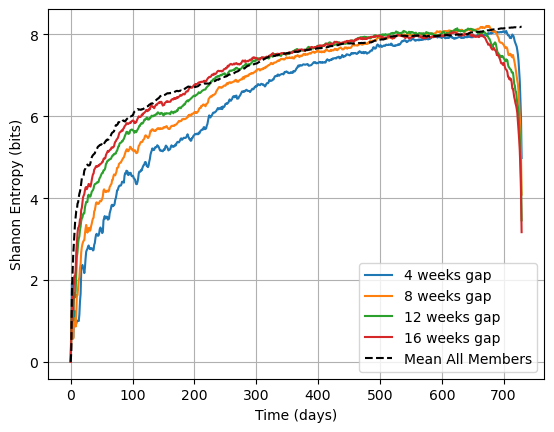

In [ ]:
for i, week in enumerate(week_range):
    file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_temporal/P_W{week:01d}_m{member:03d}.nc"
    P_m = xr.open_dataset(file_path)
    plt.plot(P_m['entropy'][:], label=f'{week} weeks gap')
    

plt.plot(mean_entropy_all_01, ls='--', color='black', label='Mean All Members')

plt.legend()
plt.ylabel('Shanon Entropy (bits)')
plt.xlabel('Time (days)')
plt.grid()

Text(0.5, 0, 'Time (days)')

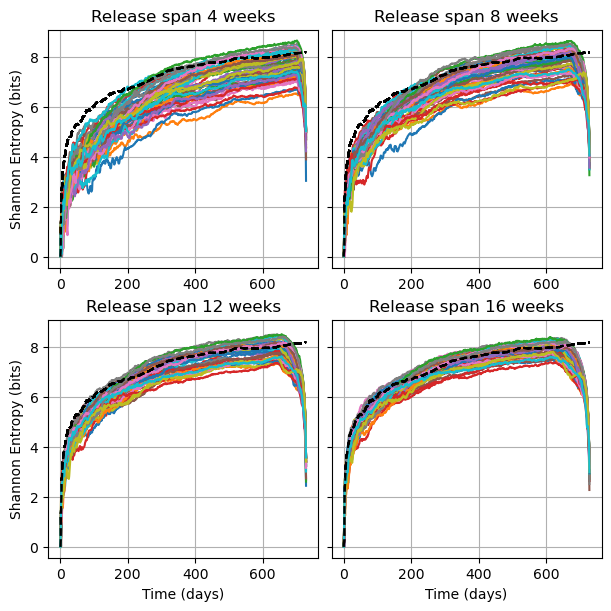

In [ ]:
member_list = range(1, 51)
ncol = 2
nrow = 2
fig, axs = plt.subplots(ncols=ncol, nrows=nrow, figsize=(6, 6),
                       sharey=True, constrained_layout=True)

axs = axs.reshape(ncol*nrow)

for i, week in enumerate(week_range):
    
    for member in member_list:
        file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_temporal/P_W{week:01d}_m{member:03d}.nc"
        P_m = xr.open_dataset(file_path)
        axs[i].plot(P_m['entropy'][:])
        axs[i].plot(mean_entropy_all_01, ls='--', color='black', label='Mean All Members')
    axs[i].grid()
    axs[i].set_title(f'Release span {week} weeks')
    # axs[i].set_xlabel('Time (days)')
    
axs[0].set_ylabel('Shannon Entropy (bits)')
axs[2].set_ylabel('Shannon Entropy (bits)')
axs[2].set_xlabel('Time (days)')
axs[3].set_xlabel('Time (days)')


Text(0.5, 0, 'Time (days)')

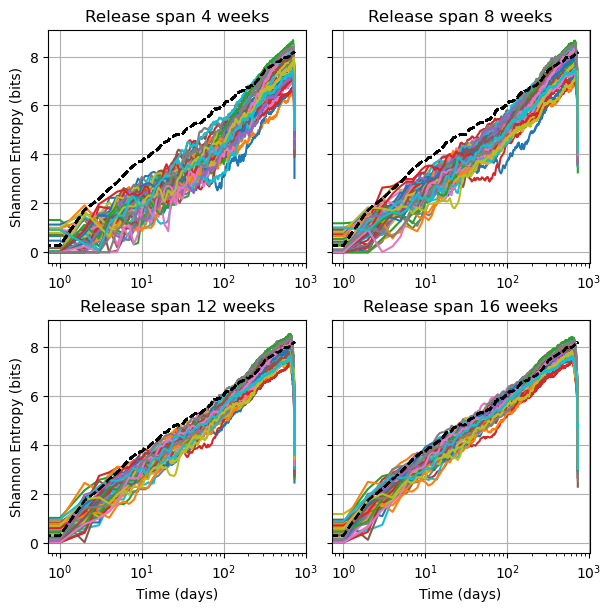

In [ ]:
member_list = range(1, 51)
ncol = 2
nrow = 2
fig, axs = plt.subplots(ncols=ncol, nrows=nrow, figsize=(6, 6),
                       sharey=True, constrained_layout=True)

axs = axs.reshape(ncol*nrow)

for i, week in enumerate(week_range):
    
    for member in member_list:
        file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_temporal/P_W{week:01d}_m{member:03d}.nc"
        P_m = xr.open_dataset(file_path)
        axs[i].semilogx(P_m['entropy'][:])
        axs[i].plot(mean_entropy_all_01, ls='--', color='black', label='Mean All Members')
    axs[i].grid()
    axs[i].set_title(f'Release span {week} weeks')
    # axs[i].set_xlabel('Time (days)')
    
axs[0].set_ylabel('Shannon Entropy (bits)')
axs[2].set_ylabel('Shannon Entropy (bits)')
axs[2].set_xlabel('Time (days)')
axs[3].set_xlabel('Time (days)')


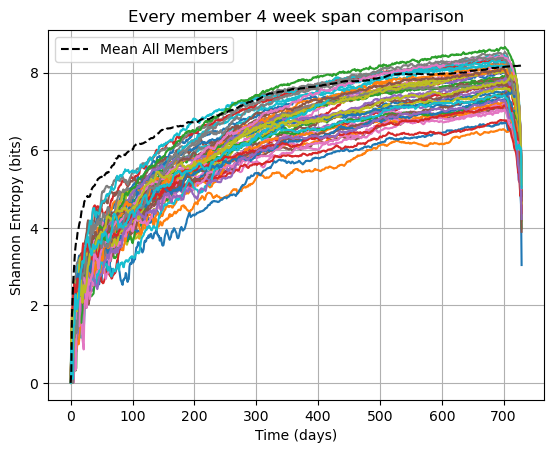

In [ ]:
week = 4
member_list = range(1, 51)

for member in member_list:
    
    file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_temporal/P_W{week:01d}_m{member:03d}.nc"
    P_m = xr.open_dataset(file_path)
    plt.plot(P_m['entropy'][:])
    
plt.plot(mean_entropy_all_01, ls='--', color='black', label='Mean All Members')

plt.legend()
plt.ylabel('Shannon Entropy (bits)')
plt.xlabel('Time (days)')
plt.title(f'Every member {week} week span comparison')
plt.grid()
# plt.xlim(0, 10)

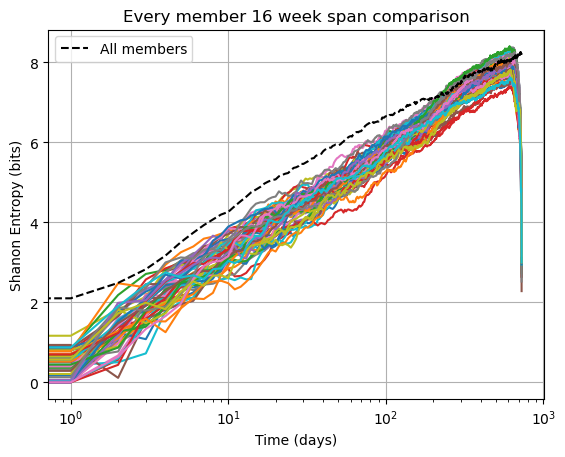

In [ ]:
week = 16
member_list = range(1, 51)

for member in member_list:
    
    file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_temporal/P_W{week:01d}_m{member:03d}.nc"
    P_m = xr.open_dataset(file_path)
    plt.plot(P_m['entropy'][:])
    
plt.semilogx(P_AX['entropy'][:], ls='--', color='black', label='All members')

plt.legend()
plt.ylabel('Shanon Entropy (bits)')
plt.xlabel('Time (days)')
plt.title(f'Every member {week} week span comparison')
plt.grid()

## Averaging all members

In [ ]:
entropies = {}
entropies_std = {}

for week in week_range:
    _entropy = np.zeros((50, len(P_AX['entropy'].values)))
    for i, member in enumerate(range(1, 51)):
        file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_temporal/P_W{week:01d}_m{member:03d}.nc"
        P_m = xr.open_dataset(file_path)
        _entropy[i, :] = P_m['entropy'].values
        
        
    entropies[week] = np.mean(_entropy, axis=0)
    entropies_std[week] = np.std(_entropy, axis=0)

In [ ]:
time_range = np.arange(1, 731)

Text(0.5, 0, 'Time (days)')

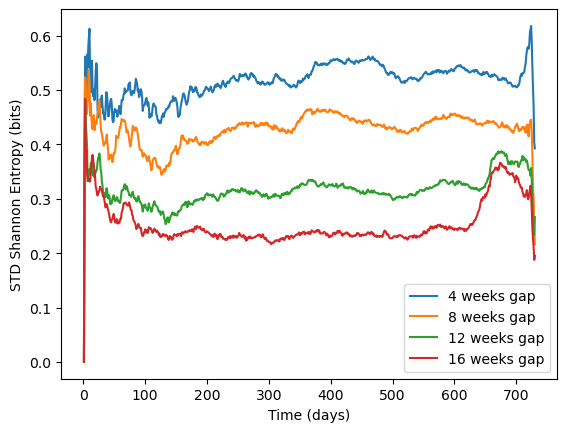

In [ ]:
for week in week_range:
    plt.plot(time_range, entropies_std[week], label=f'{week} weeks gap')
    
plt.legend()
plt.ylabel('STD Shannon Entropy (bits)')
plt.xlabel('Time (days)')

Text(0.5, 1.0, 'Average Entropy All Members Temporal')

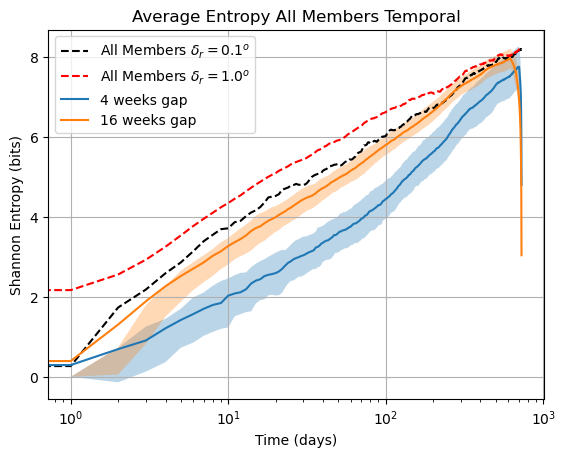

In [ ]:
plt.semilogx(mean_entropy_all_01, ls='--', color='black', label=r'All Members $\delta_r = 0.1^o$')
plt.semilogx(mean_entropy_all_10, ls='--', color='red', label=r'All Members $\delta_r = 1.0^o$')

for week in [4, 16]:
    plt.plot(entropies[week], label=f'{week} weeks gap')
    plt.fill_between(time_range, entropies[week] - entropies_std[week], entropies[week] + entropies_std[week], alpha=0.3)

plt.legend()
plt.ylabel('Shannon Entropy (bits)')
plt.xlabel('Time (days)')
plt.grid()
plt.title('Average Entropy All Members Temporal')

# Spatial analysis

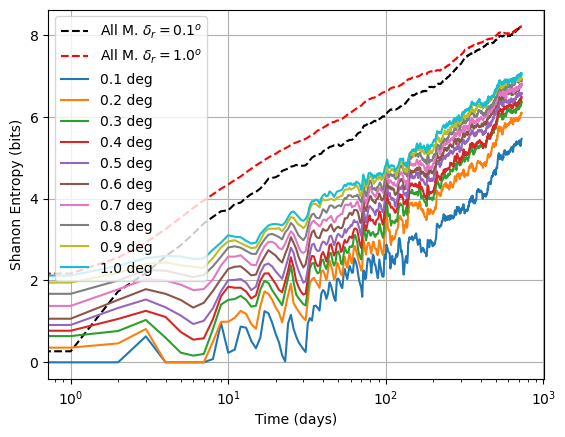

In [ ]:
member = 45

plt.semilogx(mean_entropy_all_01, ls='--', color='black', label=r'All M. $\delta_r = 0.1^o$')
plt.semilogx(mean_entropy_all_10, ls='--', color='red', label=r'All M. $\delta_r = 1.0^o$')

for i, delta_r in enumerate(delta_r_ranges):
    
    file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_spatial/P_dr{delta_r*100:03.0f}_m{member:03d}.nc"
    P_m = xr.open_dataset(file_path)
    plt.plot(P_m['entropy'][:], label=f'{delta_r:.1f} deg')
    


plt.legend()
plt.ylabel('Shanon Entropy (bits)')
plt.xlabel('Time (days)')
plt.grid()

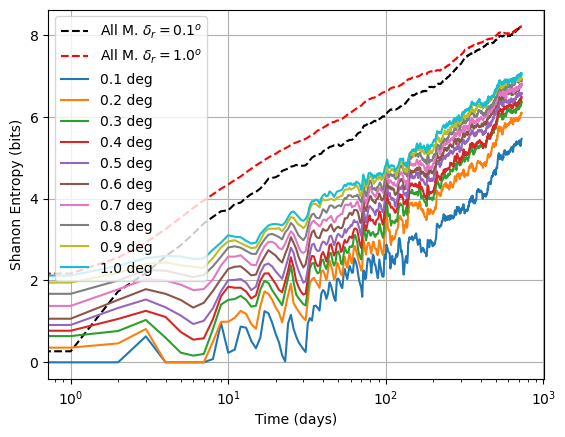

In [ ]:
plt.semilogx(mean_entropy_all_01, ls='--', color='black', label=r'All M. $\delta_r = 0.1^o$')
plt.semilogx(mean_entropy_all_10, ls='--', color='red', label=r'All M. $\delta_r = 1.0^o$')

for i, delta_r in enumerate(delta_r_ranges):
    
    file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_spatial/P_dr{delta_r*100:03.0f}_m{member:03d}.nc"
    P_m = xr.open_dataset(file_path)
    plt.plot(P_m['entropy'][:], label=f'{delta_r:.1f} deg')
    


plt.legend()
plt.ylabel('Shanon Entropy (bits)')
plt.xlabel('Time (days)')
plt.grid()

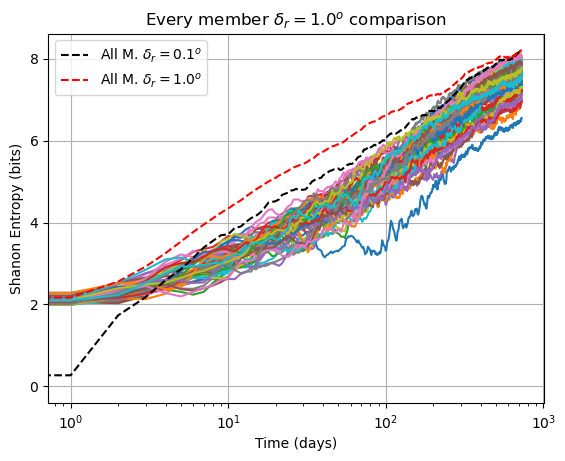

In [ ]:
delta_r = 1.

# for i, delta_r in enumerate(delta_r_ranges):
for member in range(1, 51):
    
    file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_spatial/P_dr{delta_r*100:03.0f}_m{member:03d}.nc"
    P_m = xr.open_dataset(file_path)
    plt.plot(P_m['entropy'][:])

plt.semilogx(mean_entropy_all_01, ls='--', color='black', label=r'All M. $\delta_r = 0.1^o$')
plt.semilogx(mean_entropy_all_10, ls='--', color='red', label=r'All M. $\delta_r = 1.0^o$')

plt.legend()
plt.ylabel('Shanon Entropy (bits)')
plt.xlabel('Time (days)')
plt.title(f'Every member $\\delta_r = ${delta_r:.1f}$^o$ comparison')
plt.grid()

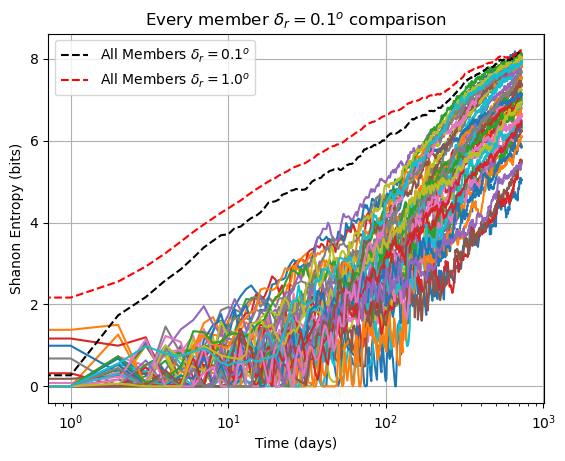

In [ ]:
delta_r = 0.1

for member in range(1, 51):
    
    file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_spatial/P_dr{delta_r*100:03.0f}_m{member:03d}.nc"
    P_m = xr.open_dataset(file_path)
    plt.plot(P_m['entropy'][:])
    
plt.semilogx(mean_entropy_all_01, ls='--', color='black', label=r'All Members $\delta_r = 0.1^o$')
plt.semilogx(mean_entropy_all_10, ls='--', color='red', label=r'All Members $\delta_r = 1.0^o$')

plt.legend()
plt.ylabel('Shanon Entropy (bits)')
plt.xlabel('Time (days)')
plt.title(f'Every member $\\delta_r = ${delta_r:.1f}$^o$ comparison')
plt.grid()

## Averaging all members

In [ ]:
entropies_spatial = {}
entropies_std_spatial = {}
    
for i, delta_r in enumerate(delta_r_ranges):
    _entropy = np.zeros((50, len(P_AX['entropy'].values)))
    for i, member in enumerate(range(1, 51)):
        file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_spatial/P_dr{delta_r*100:03.0f}_m{member:03d}.nc"
        P_m = xr.open_dataset(file_path)
        
        _entropy[i, :] = P_m['entropy'].values
        
        
    entropies_spatial[delta_r] = np.mean(_entropy, axis=0)
    entropies_std_spatial[delta_r] = np.std(_entropy, axis=0)

In [ ]:
plt.semilogx(mean_entropy_all_01, ls='--', color='black', label=r'All Members $\delta_r = 0.1^o$')
plt.semilogx(mean_entropy_all_10, ls='--', color='red', label=r'All Members $\delta_r = 1.0^o$')

for delta_r in [0.1, 1]:
    plt.plot(entropies_spatial[delta_r], label=f'${delta_r:.1f}^o$')
    plt.fill_between(time_range, entropies_spatial[delta_r] - entropies_std_spatial[delta_r], entropies_spatial[delta_r] + entropies_std_spatial[delta_r], alpha=0.3)


plt.legend()
plt.ylabel('Shannon Entropy (bits)')
plt.xlabel('Time (days)')
plt.grid()
plt.title('Average Shannon Entropy All Members Spatial')


Text(0.5, 1.0, 'Average Shannon Entropy All Members Spatial')

Error in callback <function _draw_all_if_interactive at 0x7f1878aaa980> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

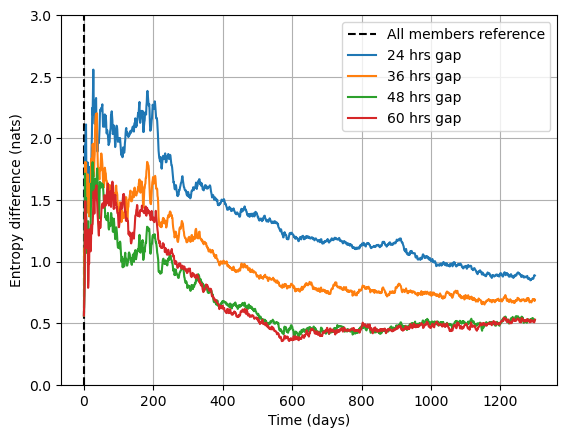

In [ ]:
# plt.plot(P_AX['entropy'][0, :1300], ls='--', color='black', label='All members')

plt.axvline(0, color='black', ls='--', label="All members reference")
for i, dt in enumerate(delta_t_array):
    plt.plot(P_AX['entropy'][0, :1300] - P_m['entropy'][i, :1300], label=f'{dt} hrs gap')
    
plt.legend()
plt.ylabel('Entropy difference (nats)')
plt.xlabel('Time (days)')
plt.ylim(0, 3)
plt.grid()

In [ ]:
def compute_h_timescales(h_ref, h_m):
    """
    Computes the timescales at which the entropy values in P_m reach the same or higher values as in P_AX.

    Parameters:
    - P_AX: DataFrame or similar structure with 'entropy' values for reference.
    - P_m: DataFrame or similar structure with 'entropy' values to compare.
    - i: Index to select the specific member in P_m for comparison.

    Returns:
    - h_timescales: A numpy array containing the computed timescales.
    """
    max_h = np.nanmax(h_m)
    h_range = np.linspace(0.1, max_h, 20)

    h_timescales = np.zeros_like(h_range)

    for j, h_i in enumerate(h_range):
        idx_ref = np.where(h_ref >= h_i)[0]
        idx_m = np.where(h_m >= h_i)[0]
        if len(idx_ref) > 0 and len(idx_m) > 0:
            h_timescales[j] = idx_m[0] - idx_ref[0]
        else:
            h_timescales[j] = np.nan  # Assign NaN if no matching index is found

    return h_timescales, h_range

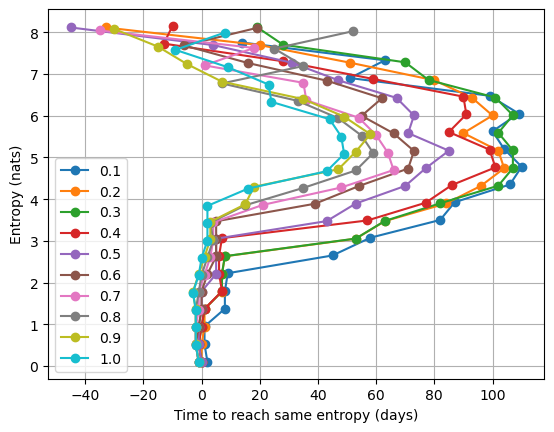

In [ ]:
for i, delta_r in enumerate(delta_r_ranges):
    
    file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_spatial/P_dr{delta_r*100:03.0f}_m{member:03d}.zarr"
    P_m = xr.open_zarr(file_path)
    
    x, y =  compute_h_timescales(P_AX['entropy'], P_m['entropy'])
    plt.plot(x,y, marker='o', label=f'{delta_r}')

plt.grid()
plt.xlabel('Time to reach same entropy (days)')
plt.ylabel('Entropy (nats)')
plt.legend()

In [ ]:
hex_grid = hexfunc.int_to_hex(P_m.hexint.values)
hexbin_grid = hexfunc.hexGrid(hex_grid, h3_res=3)

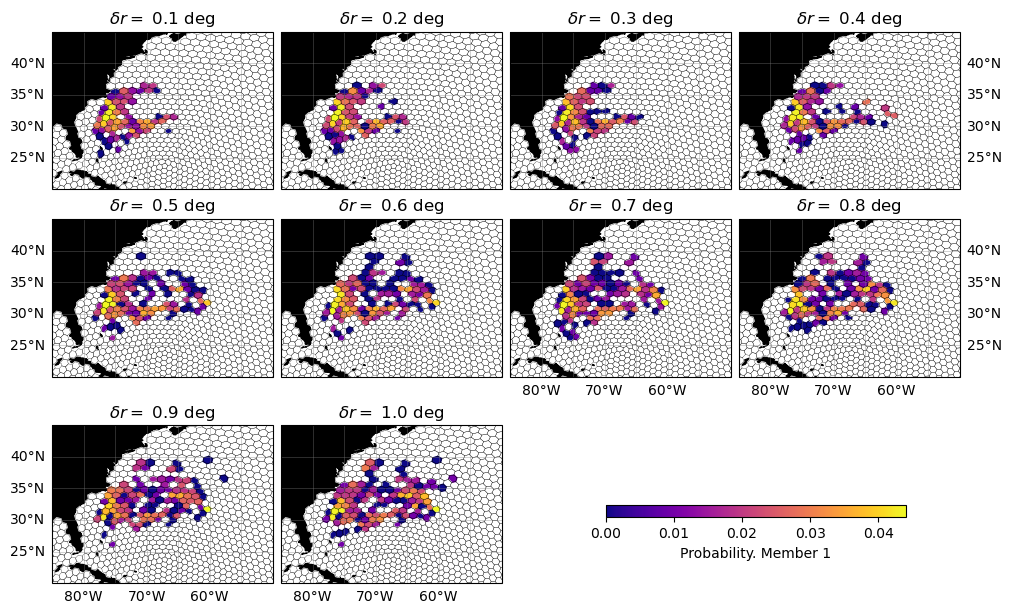

In [ ]:
ncol = 4
nrow = 3
fig, axs = plt.subplots(ncols=ncol, nrows=nrow, figsize=(10, 6),
                       subplot_kw={'projection': cartopy.crs.PlateCarree()},
                       sharey=True, constrained_layout=True)

axs = axs.reshape(ncol*nrow)
t = 150

for i, delta_r in enumerate(delta_r_ranges):
    
    file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_spatial/P_dr{delta_r*100:03.0f}_m{member:03d}.zarr"
    P_m = xr.open_zarr(file_path)
    
    axs[i].set_extent([-85, -50, 20, 45], crs=cartopy.crs.PlateCarree())
    axs[i].add_feature(cartopy.feature.LAND, zorder=0, color='black')
    
    axs[i].set_title(f'$\\delta r =$ {delta_r} deg')
    gl = axs[i].gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,
                         linewidth=0.5, color='gray', alpha=0.5)

    im = hexbin_grid.pcolorhex(P_m['probability'][:, t].values, ax=axs[i], cmap='plasma', draw_edges=True)
    
    
    if i in [1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 15, 17, 18, 19]:
        gl.left_labels = False

    if i < 6:
        gl.bottom_labels = False

    gl.top_labels = False
    gl.right_labels = False

    if i in [3, 7, 11, 15, 19]:
        gl.right_labels = True

for i in range(ncol*nrow - nrow + 1, ncol*nrow):
    axs[i].axis('off')

# ax[12].legend(handles=[h], loc='upper center', shadow=True)
# bar_ax = fig.add_axes([0.1, 0.07, 0.8, 0.02])
bar_ax = fig.add_axes([0.6, 0.15, 0.3, 0.02])
cbar = fig.colorbar(im, cax=bar_ax, orientation='horizontal', label=f'Probability. Member {member}')



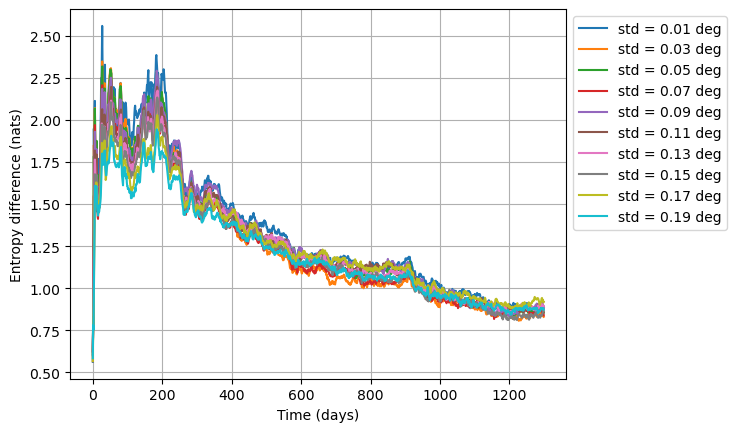

In [ ]:
for i, std in enumerate(std_ranges[::2]):
    
    file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_coarse/P_std{std*100:03.0f}_m{member:03d}.zarr"
    P_m = xr.open_zarr(file_path)
    
    file_path_AX = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_coarse/P_std{std*100:03.0f}_all.zarr"
    P_AX = xr.open_zarr(file_path_AX)
    
    plt.plot(P_AX['entropy'][0, :1300] - P_m['entropy'][0, :1300], label=f'std = {std} deg')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylabel('Entropy difference (nats)')
plt.xlabel('Time (days)')
plt.grid()

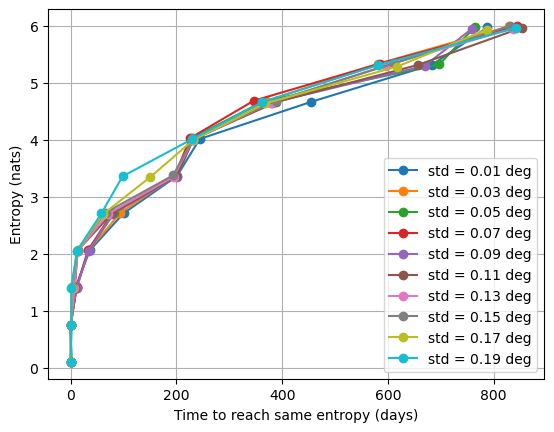

In [ ]:
for i, std in enumerate(std_ranges[::2]):
    
    file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_coarse/P_std{std*100:03.0f}_m{member:03d}.zarr"
    P_m = xr.open_zarr(file_path)
    
    file_path_AX = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_coarse/P_std{std*100:03.0f}_all.zarr"
    P_AX = xr.open_zarr(file_path_AX)
    
    x, y =  compute_h_timescales(P_AX, P_m, 0)
    plt.plot(x,y, marker='o', label=f'std = {std} deg')

plt.grid()
plt.xlabel('Time to reach same entropy (days)')
plt.ylabel('Entropy (nats)')
plt.legend()

# New set of simulations SPATIAL

In [ ]:
location = 'Cape_Hatteras'
member = 1
delta_r = 0.1

file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_spatial/P_dr{delta_r*100:03.0f}_m{member:03d}.zarr"
P_m = xr.open_zarr(file_path)

hex_grid = hexfunc.int_to_hex(P_m.hexint.values)
hexbin_grid = hexfunc.hexGrid(hex_grid, h3_res=3)


In [ ]:
P_m['entropy']

<xarray.DataArray 'entropy' (time: 730)> Size: 6kB
dask.array<open_dataset-entropy, shape=(730,), dtype=float64, chunksize=(730,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int32 3kB 0 1 2 3 4 5 6 7 ... 723 724 725 726 727 728 729
Attributes:
    description:  Entropy values for each time step and observation time
    units:        bits

In [ ]:
location = 'Cape_Hatteras'
N_members = 7
N_obs = len(P_m.time)
H = np.zeros((N_members, N_obs))
delta_r = 1.

for member in range(1,N_members+1):
    print(f"Member {member}")
    
    file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_spatial/P_dr{delta_r*100:03.0f}_m{member:03d}.zarr"
    P_m = xr.open_zarr(file_path)
    
    H[member-1, :] = P_m['entropy'].values

Member 1
Member 2
Member 3
Member 4
Member 5
Member 6
Member 7


Text(0.5, 1.0, 'Entropy from $\\delta r = 1.0$')

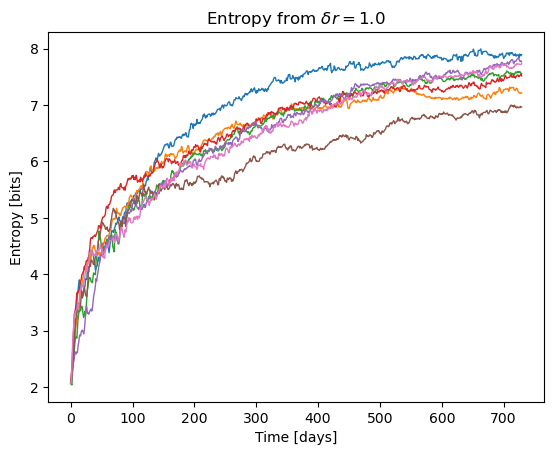

In [ ]:
for i in range(7):
    plt.plot(H[i,:], lw=1)
    
plt.xlabel('Time [days]')
plt.ylabel('Entropy [bits]')
plt.title(f"Entropy from $\\delta r = {delta_r}$")

Member 1
Member 2
Member 3
Member 4
Member 5
Member 6
Member 7


Text(0.5, 1.0, 'Entropy from $\\delta r = 0.1$')

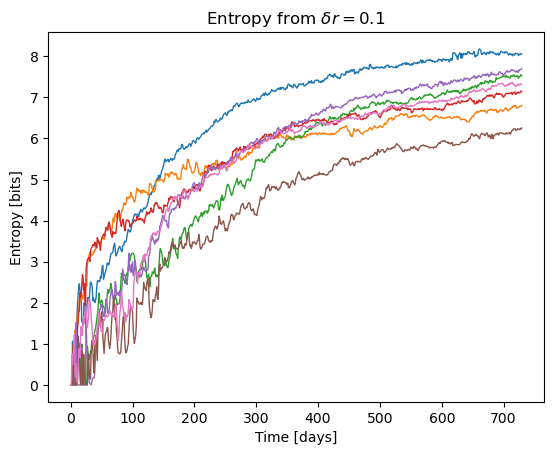

In [ ]:
location = 'Cape_Hatteras'
N_members = 7
N_obs = len(P_m.time)
H = np.zeros((N_members, N_obs))
delta_r = 0.1

for member in range(1,N_members+1):
    print(f"Member {member}")
    
    file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_spatial/P_dr{delta_r*100:03.0f}_m{member:03d}.zarr"
    P_m = xr.open_zarr(file_path)
    
    H[member-1, :] = P_m['entropy'].values
    
for i in range(7):
    plt.plot(H[i,:], lw=1)
    
plt.xlabel('Time [days]')
plt.ylabel('Entropy [bits]')
plt.title(f"Entropy from $\\delta r = {delta_r}$")